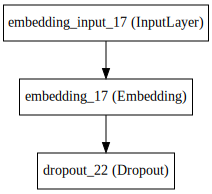

In [10]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Activation, Dense, Merge, Permute, Dropout
from keras.layers import LSTM

vocab_size = 22
story_maxlen = 68
query_maxlen = 4

# embed the input sequence into a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=64,
                              input_length=story_maxlen))
input_encoder_m.add(Dropout(0.3))
# output: (samples, story_maxlen, embedding_dim)
# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=64,
                               input_length=query_maxlen))
question_encoder.add(Dropout(0.3))
# output: (samples, query_maxlen, embedding_dim)
# compute a 'match' between input sequence elements (which are vectors)
# and the question vector sequence
match = Sequential()
match.add(Merge([input_encoder_m, question_encoder],
                mode='dot',
                dot_axes=[2, 2]))
# output: (samples, story_maxlen, query_maxlen)
# embed the input into a single vector with size = story_maxlen:
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=query_maxlen,
                              input_length=story_maxlen))
input_encoder_c.add(Dropout(0.3))
# output: (samples, story_maxlen, query_maxlen)
# sum the match vector with the input vector:
response = Sequential()
response.add(Merge([match, input_encoder_c], mode='sum'))
# output: (samples, story_maxlen, query_maxlen)
response.add(Permute((2, 1)))  # output: (samples, query_maxlen, story_maxlen)

# concatenate the match vector with the question vector,
# and do logistic regression on top
answer = Sequential()
answer.add(Merge([response, question_encoder], mode='concat', concat_axis=-1))
# the original paper uses a matrix multiplication for this reduction step.
# we choose to use a RNN instead.
answer.add(LSTM(32))
# one regularization layer -- more would probably be needed.
answer.add(Dropout(0.3))
answer.add(Dense(vocab_size))
# we output a probability distribution over the vocabulary
answer.add(Activation('softmax'))

SVG(model_to_dot(input_encoder_m).create(prog='dot', format='svg'))

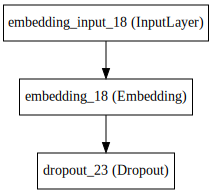

In [11]:
SVG(model_to_dot(question_encoder).create(prog='dot', format='svg'))

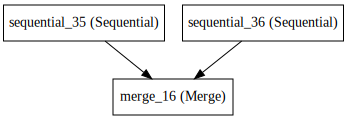

In [12]:
SVG(model_to_dot(match).create(prog='dot', format='svg'))

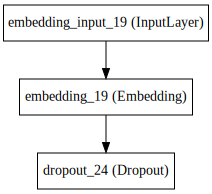

In [13]:
SVG(model_to_dot(input_encoder_c).create(prog='dot', format='svg'))

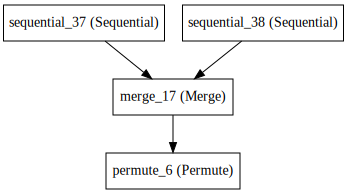

In [14]:
SVG(model_to_dot(response).create(prog='dot', format='svg'))

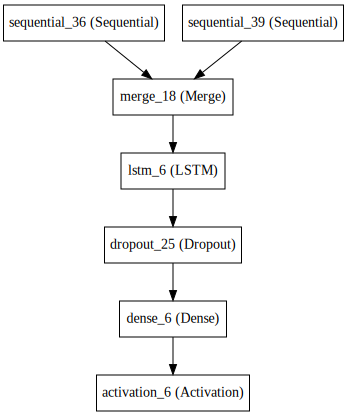

In [15]:
SVG(model_to_dot(answer).create(prog='dot', format='svg'))